In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle

path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib.models.aln import ALNModel
from neurolib.utils import plotFunctions as plotFunc
from neurolib.utils import costFunctions as cost
import neurolib.dashboard.functions as functions
import neurolib.dashboard.data as data
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

not here


In [2]:
grid_data_file = os.path.join(os.getcwd().split('data')[0], 'bi.pickle')
with open(grid_data_file,'rb') as f:
    load_array= pickle.load(f)
exc = [load_array[0][20], load_array[0][50]]
inh = [load_array[1][20], load_array[1][50]]

folder = str(os.getcwd().split('data_2')[1])
print(folder)
case = str(folder[1])

file_ = 'down.pickle'

c_var = [0,1]
if len(folder) == 4:
    if folder[3] == 'e':
        p_var = [0]
    elif folder[3] == 'i':
        p_var = [1]
else:
    p_var = [0,1]
    
print(p_var)

step1 = 100
step2 = 10
step3 = 1

/1_e
[0]


In [3]:
aln = ALNModel()
N = aln.params.N

data.set_parameters(aln)

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

In [4]:
d_array = np.arange(500., 20, -0.1)
t0_array = d_array - 20.
t_pen = np.zeros(( t0_array.shape ))
for i in range(len(t_pen)):
    t_pen[i] = t0_array[i] / d_array[i]

In [5]:
dt = 0.01
aln.params.dt = dt
dur_pre = 10
dur_post = 10

n_pre = int(np.around(dur_pre/aln.params.dt + 1.,1))
n_post = int(np.around(dur_post/aln.params.dt + 1.,1))

tol = 1e-8
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

if case in ['1', '2']:    # low to high
    max_I = [3., -3.]
else:
    max_I = [-3., 3.]
    
if case in ['1', '3']:    # sparsity
    factor_ws = 1.
    factor_we = 0.
else:
    factor_ws = 0.
    factor_we = 1.
    
maxC = [1000., -1000., 0.18, 0.]
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

In [6]:
bestControl_ = np.array( [[None] * len(t_pen)] * len(exc) )
bestState_ = np.array( [[None] * len(t_pen)] * len(exc) )
cost_ = np.array( [[None] * len(t_pen)] * len(exc) )
costnode_ = np.array( [[None] * len(t_pen)] * len(exc) )
weights_ = np.array( [[None] * len(t_pen)] * len(exc) )
convergence_ = np.array( [[None] * len(t_pen)] * len(exc) )

initVars = [None] * len(exc)
target = [None] * len(exc)
cost_uncontrolled = [None] * len(exc)

print(bestControl_.shape)

(2, 4800)


In [7]:
if os.path.isfile(file_) :
    print("file found")
    
    with open(file_,'rb') as f:
        load_array = pickle.load(f)

    bestControl_ = load_array[0]

file found


In [ ]:
bC_dt_1 = [None] * 3

In [38]:
# get initial parameters and target states

data.set_parameters(aln)

i_range = [0]

for i in i_range:
    print("------- ", i, exc[i], inh[i])
    aln.params.ext_exc_current = exc[i] * 5.
    aln.params.ext_inh_current = inh[i] * 5.
    
    aln.params.duration = 3000.
    
    control0 = aln.getZeroControl()
    control0 = functions.step_control(aln, maxI_ = max_I[0])

    aln.run(control=control0)
    
    target_rates = np.zeros((2))
    target_rates[0] = aln.rates_exc[0,-1] 
    target_rates[1] = aln.rates_inh[0,-1]

    control0 = functions.step_control(aln, maxI_ = max_I[1])
    aln.run(control=control0)

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars[i] = init_state_vars
    target[i] = [target_rates[0], target_rates[1]]

-------  0 0.4500000000000001 0.4750000000000002


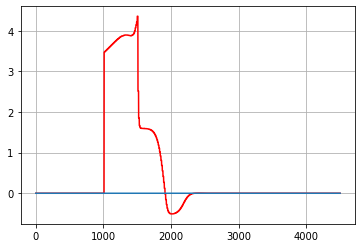

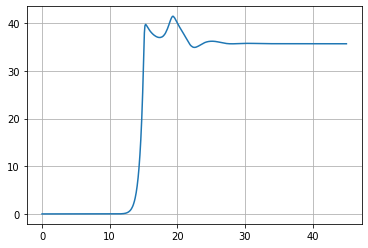

In [91]:
i = 0
j_ = [0, 1000, 4000, 4750]

for j in range(len(bC_dt)):
    if j != 3:
        continue
    
    aln.params.duration = d_array[j_[j]] + 20
    bC_dt[j] = aln.getZeroControl()
    for t in range(bestControl_[i][j_[j]].shape[2]-201):
        for k in range(10):
            bC_dt[j][:,:,1000+int(t*10)+k] = 1.0 *  bestControl_[i][j_[j]][:,:,int(100+t)]
            
    plt.plot(np.arange(bC_dt[j].shape[2]), bC_dt[j][0,0,:], color='red')
    plt.plot(np.arange(bC_dt[j].shape[2]), bC_dt[j][0,1,:])
    plt.show()
    
    aln.params.duration = d_array[j_[j]] + 20
    setinit(initVars[0], aln)
    aln.run(control= bC_dt[j])
    plt.plot(aln.t, aln.rates_exc[0,:])
    plt.show()    
    


In [101]:
tol = 1e-12
costnode_ = [None] * 4

aln.params.ext_exc_current = exc[0] * 5.
aln.params.ext_inh_current = inh[0] * 5.

for i in range(len(j_)):
    
    if i > 1:

        j = j_[i]

        dur = d_array[j]
        aln.params.duration = dur

        wp = 1. / 20.
        cost.setParams(wp, 0., 1.)
        setinit(initVars[0], aln)
        max_it = 300

        target_ = aln.getZeroTarget()
        target_[:,0,:] = target[0][0]
        target_[:,1,:] = target[0][1]

        control0 = bC_dt[i][:,:,1000:-1000]

        bC_dt[i], bs_, c_, runtime_, grad_, phi_, phi1_, costnode_[i] = aln.A1(
            control0, target_, c_scheme, u_mat, u_scheme, max_iteration_ = max_it, tolerance_ = tol,
            startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl, t_sim_ = dur,
            t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None, control_variables_ = c_var,
            prec_variables_ = p_var, transition_time_ = t_pen[j])
        
        with open('down-dt.pickle','wb') as f:
            pickle.dump([bC_dt, bs_, c_, costnode_, None], f)

set cost params:  0.05 0.0 1.0
interpolate adjoint :  True True True
initial cost =  3.4414616846334516
RUN  0 , total integrated cost =  3.4414616846334516
Gradient descend method:  None
RUN  1 , total integrated cost =  3.4414616846334516
Control only changes marginally.
RUN  1 , total integrated cost =  3.4414616846334516
Improved over  1  iterations in  0.9648937500023749  seconds by  0.0  percent.
set cost params:  0.05 0.0 1.0
interpolate adjoint :  True True True
initial cost =  8.87227982734556
RUN  0 , total integrated cost =  8.87227982734556
Gradient descend method:  None
RUN  1 , total integrated cost =  8.872279827329939
RUN  2 , total integrated cost =  8.872279827325182
RUN  3 , total integrated cost =  8.872279827325182
Control only changes marginally.
RUN  3 , total integrated cost =  8.872279827325182
Improved over  3  iterations in  1.020269303000532  seconds by  2.2967583390709478e-10  percent.


In [94]:
print(len(bC_dt))

with open('down-dt.pickle','wb') as f:
    pickle.dump([bC_dt, bs_, c_, costnode_, None], f)

4


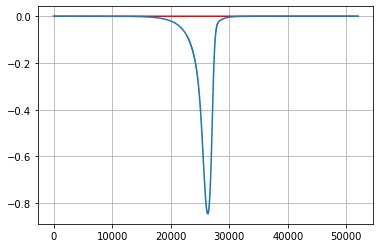

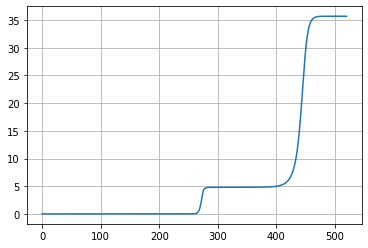

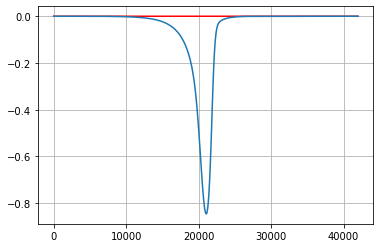

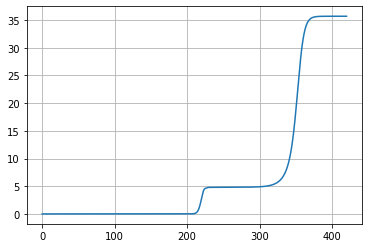

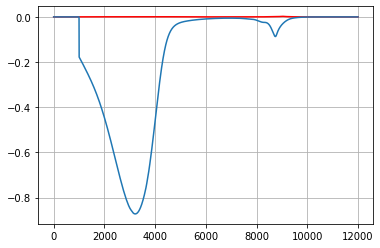

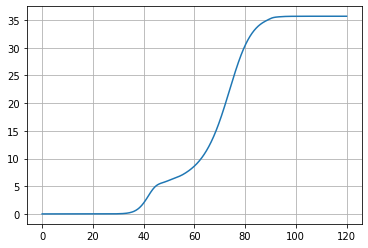

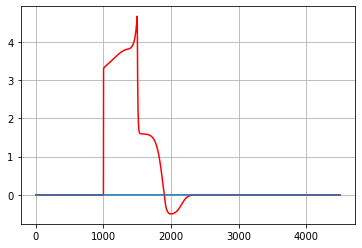

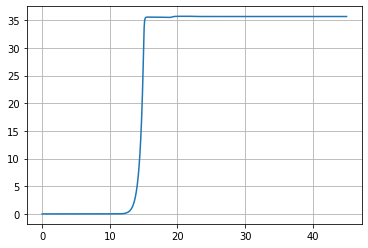

In [102]:
for j in range(len(bC_dt)):
    aln.params.duration = d_array[j_[j]] + 20
            
    plt.plot(np.arange(bC_dt[j].shape[2]), bC_dt[j][0,0,:], color='red')
    plt.plot(np.arange(bC_dt[j].shape[2]), bC_dt[j][0,1,:])
    plt.show()
    
    aln.params.duration = d_array[j_[j]] + 20
    setinit(initVars[0], aln)
    aln.run(control= bC_dt[j])
    plt.plot(aln.t, aln.rates_exc[0,:])
    plt.show() 

In [73]:
diff = [None] * 3

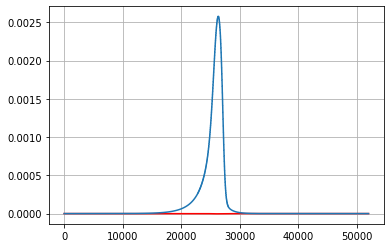

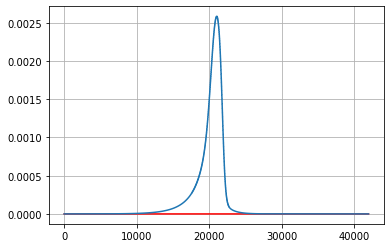

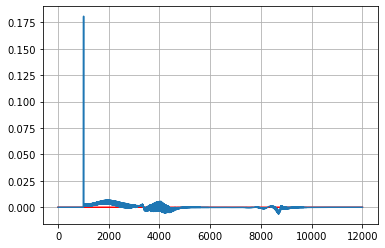

In [77]:
i = 0
for j in range(len(bC_dt)):
    aln.params.duration = d_array[j_[j]] + 20
    diff[j] = aln.getZeroControl()
    for t in range(bestControl_[i][j_[j]].shape[2]-1):
        for k in range(10):
            diff[j][:,:,int(t*10)+k] = bestControl_[i][j_[j]][:,:,t] - bC_dt[j][:,:,int(t*10)+k]
            
    plt.plot(np.arange(diff[j].shape[2]), diff[j][0,0,:], color='red')
    plt.plot(np.arange(diff[j].shape[2]), diff[j][0,1,:])
    plt.show()

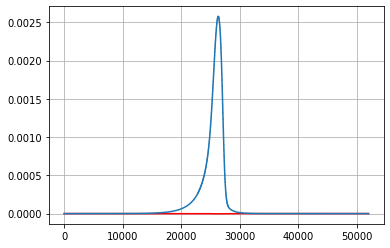

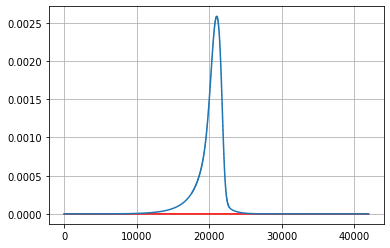

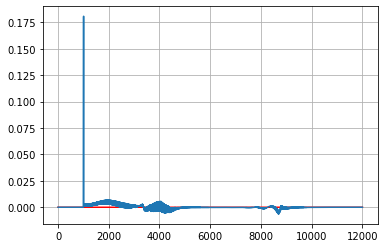

In [79]:
i = 0
for j in range(len(bC_dt)):
    aln.params.duration = d_array[j_[j]] + 20
    diff[j] = aln.getZeroControl()
    for t in range(bestControl_[i][j_[j]].shape[2]-1):
        for k in range(10):
            diff[j][:,:,int(t*10)+k] = bestControl_[i][j_[j]][:,:,t] - bC_dt[j][:,:,int(t*10)+k]
            
    plt.plot(np.arange(diff[j].shape[2]), diff[j][0,0,:], color='red')
    plt.plot(np.arange(diff[j].shape[2]), diff[j][0,1,:])
    plt.show()